In [20]:
import numpy as np
from qiskit import *
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram
from qiskit.tools.jupyter import *
#IBMQ.save_account(TOKEN)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-08-07 11:38:45,437: Credentials are already in use. The existing account in the session will be replaced.


In [9]:
def phase_oracle(n, indices):
    qc = QuantumCircuit(n, name='Oracle')
    oracle_matrix = np.identity(2**n)
    
    for i in indices:
        oracle_matrix[i, i] = -1
    
    qc.unitary(Operator(oracle_matrix), range(n))
    
    return qc

In [10]:
def diffuser(n):
    qc = QuantumCircuit(n, name='Diffuser')
    
    qc.h(range(n))
    qc.append(phase_oracle(n,[0]), range(n))
    qc.h(range(n))
    
    return qc

In [11]:
def Grover(n, marked):
    qc = QuantumCircuit(n, n)
    r = int(np.round(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2)) #number of phase and diffuser rounds
    
    print(f'{n} qubits, basis state {marked} marked, {r} rounds')
    
    qc.h(range(n))
    
    for _ in range(r):
        qc.append(phase_oracle(n, marked), range(n))
        qc.append(diffuser(n), range(n))
    
    qc.measure(range(n), range(n))
    
    return qc

5 qubits, basis state [7] marked, 4 rounds


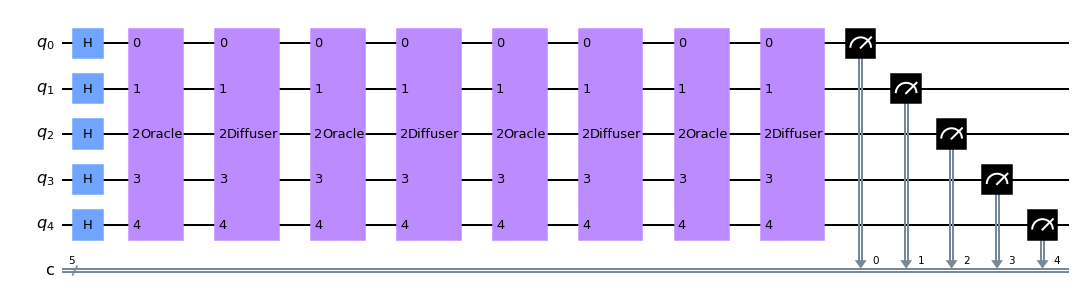

In [12]:
n = 5
x = np.random.randint(2**n) # marked element
qc = Grover(n, [x])

qc.draw(output='mpl')

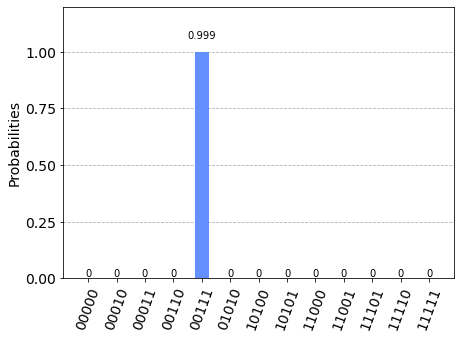

In [14]:
sim = Aer.get_backend('qasm_simulator')
result = execute(qc, backend = sim, shots = 10000).result()
counts = result.get_counts()
plot_histogram(counts)

In [21]:
n = 3

x = np.random.randint(2**n)
y = np.random.randint(2**n)

while x == y:
    y = np.random.randint(2**n)
    
marked = [x, y]
qc = Grover(n, marked)

backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and
                                      not x.configuration().simulator and x.status().operational==True))

print("Least busy: ", backend)

%qiskit_job_watcher

job = execute(qc, backend=backend, shots=1024, optimization_level=3)

3 qubits, basis state [0, 3] marked, 1 rounds
Least busy:  ibmq_manila


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

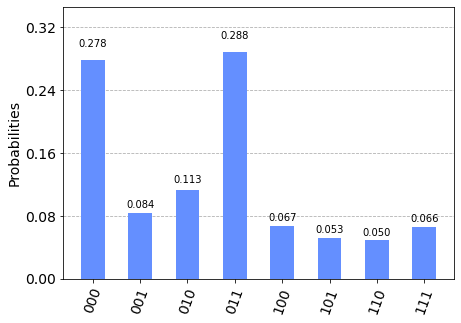

In [22]:
counts = job.result().get_counts()
plot_histogram(counts)